In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.datasets import make_imbalance
from imblearn.under_sampling import (RandomUnderSampler, ClusterCentroids, TomekLinks, 
                                     NeighbourhoodCleaningRule,NearMiss)

C:\Users\PC Klinik\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\PC Klinik\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:43:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


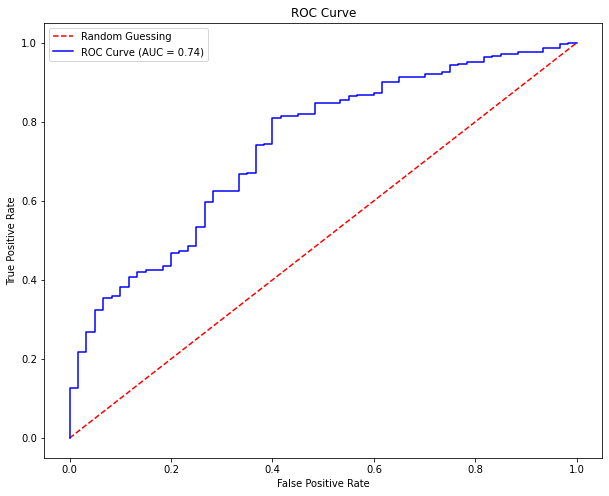

In [65]:
df = pd.read_csv("./data/responses_subset.csv")

X = df.loc[:,df.dtypes!='object'].copy()
X.drop('Age',axis=1, inplace=True)
y = np.where(df.Age >=19,1,0)
y = pd.Series(y)

X_train ,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, shuffle=True)

model = XGBClassifier()
model.fit(X_train,y_train)

pred_proba = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:,1])
random_probs = [0 for _ in range(len(y_test))]
fpr_random, tpr_random, thresholds_random = roc_curve(y_test, random_probs)

plt.figure(figsize=(10,8))
plt.title('ROC Curve')
plt.plot(fpr_random, tpr_random,linestyle='--', c='r',label='Random Guessing')
plt.plot(fpr,tpr,c='b',label=f'ROC Curve (AUC = {round(roc_auc_score(y_test,pred_proba[:,1]),2)})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

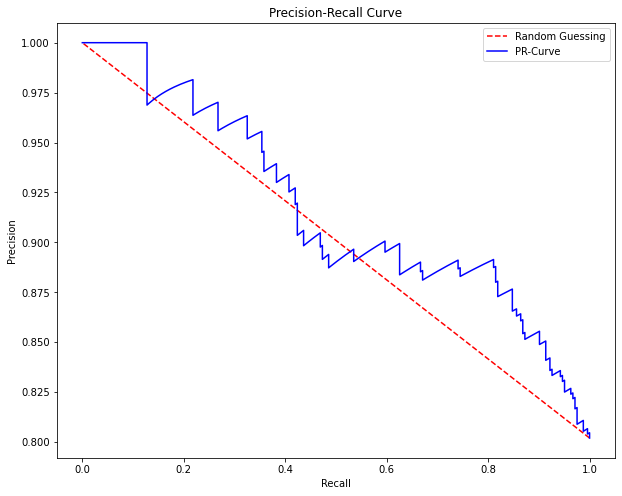

In [66]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba[:,1])
precision_random, recall_random, thresholds_random = precision_recall_curve(y_test, random_probs)

plt.figure(figsize=(10,8))
plt.title('Precision-Recall Curve')
plt.plot(recall_random, precision_random,linestyle='--', c='r',label='Random Guessing')
plt.plot(recall,precision,c='b',label='PR-Curve')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [68]:
X, y = datasets.make_classification(n_samples = 4000,  n_classes = 2, n_clusters_per_class = 2, weights = [0.03,0.97], 
                                    n_features = 10, n_informative = 2, n_redundant = 2, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f'Original class distribution {Counter(y)}')
print(f'Training class distribution {Counter(y_train)}')

Original class distribution Counter({1: 3864, 0: 136})
Training class distribution Counter({1: 2589, 0: 91})


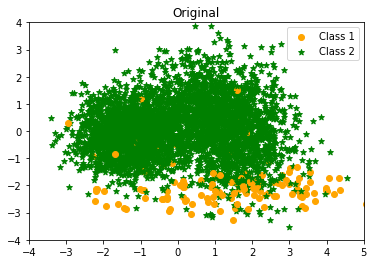

In [74]:
def plot_data(X,y,method):
    
    # Use principal component to condense the 10 features to 2 features
    pca = PCA(n_components=2).fit(X)
    pca_2d = pca.transform(X)
    
    # Assign colors
    for i in range(0, pca_2d.shape[0]):
        if y[i] == 0:
            c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1], c='orange', marker='o')
        elif y[i] == 1:
            c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1], c='g', marker='*')  
    
    plt.legend([c1, c2], ['Class 1', 'Class 2'])
    plt.title(method)
    plt.axis([-4, 5, -4, 4]) 
    plt.show()
    
plot_data(X,y,'Original')

Random undersampling Counter({1: 1000, 0: 65})


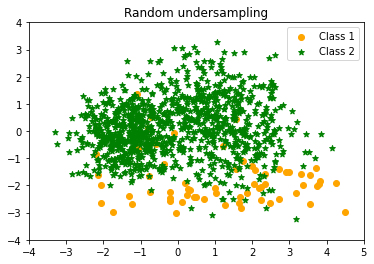

In [76]:
X_rs, y_rs = make_imbalance(X, y, sampling_strategy={1: 1000, 0: 65},
                      random_state=0)
print(f'Random undersampling {Counter(y_rs)}')
plot_data(X_rs,y_rs,'Random undersampling')

Random undersampling Counter({1: 1000, 0: 65})


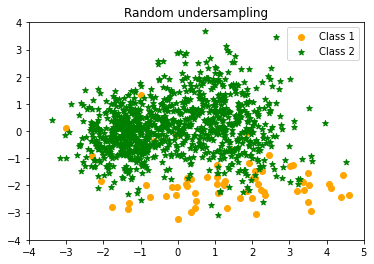

C:\Users\PC Klinik\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster centriods undersampling Counter({1: 1000, 0: 65})


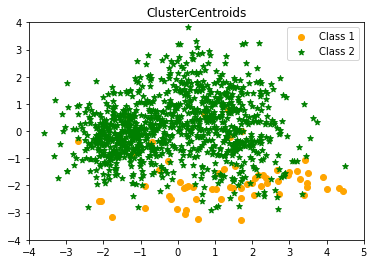

TomekLinks undersampling Counter({1: 2575, 0: 91})


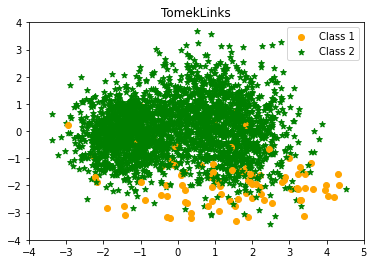

NearestNeighbours Clearning Rule undersampling Counter({1: 2522, 0: 91})


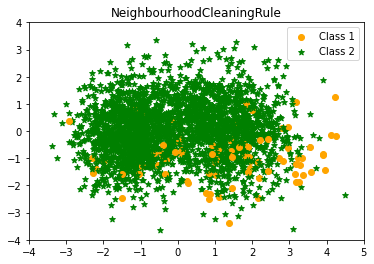

NearMissCounter({0: 91, 1: 91})


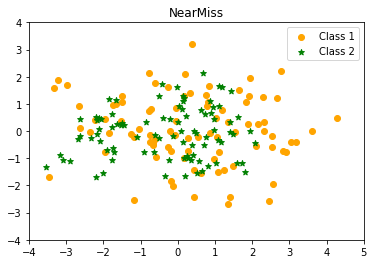

In [78]:
# RandomUnderSampler
sampler = RandomUnderSampler(sampling_strategy={1: 1000, 0: 65})
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(f'Random undersampling {Counter(y_rs)}')
plot_data(X_rs,y_rs,'Random undersampling')

# ClusterCentroids
sampler = ClusterCentroids(sampling_strategy={1: 1000, 0: 65})
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(f'Cluster centriods undersampling {Counter(y_rs)}')
plot_data(X_rs,y_rs,'ClusterCentroids')

# TomekLinks
sampler = TomekLinks() 
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(f'TomekLinks undersampling {Counter(y_rs)}')
plot_data(X_rs,y_rs,'TomekLinks')

# NeighbourhoodCleaningRule
sampler = NeighbourhoodCleaningRule() 
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(f'NearestNeighbours Clearning Rule undersampling {Counter(y_rs)}')
plot_data(X_rs,y_rs,'NeighbourhoodCleaningRule')

# NearMiss
sampler = NearMiss() 
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(f'NearMiss{Counter(y_rs)}')
plot_data(X_rs,y_rs,'NearMiss')

C:\Users\PC Klinik\anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (2590) in class 1 will be larger than the number of samples in the majority class (class #1 -> 2589)
  warnings.warn(


RandomOverSampler Counter({1: 2590, 0: 300})


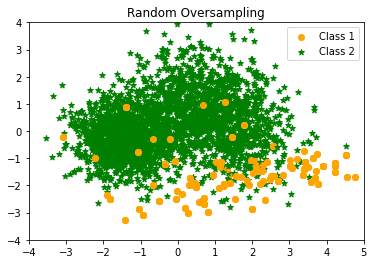

C:\Users\PC Klinik\anaconda3\lib\site-packages\imblearn\utils\_validation.py:299: UserWarning: After over-sampling, the number of samples (2590) in class 1 will be larger than the number of samples in the majority class (class #1 -> 2589)
  warnings.warn(


SMOTE Counter({1: 2590, 0: 300})


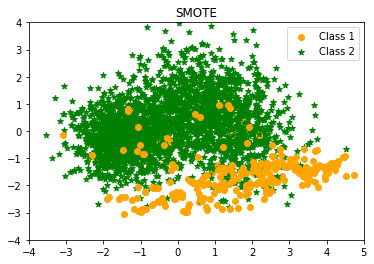

ADASYN Counter({0: 2604, 1: 2589})


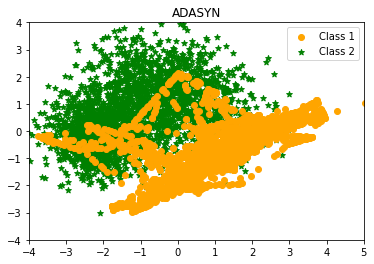

In [82]:
from imblearn.over_sampling import (RandomOverSampler, 
                                    SMOTE, 
                                    ADASYN)
# RandomOverSampler
  # With over-sampling methods, the number of samples in a class
  # should be greater or equal to the original number of samples.
sampler = RandomOverSampler(sampling_strategy={1: 2590, 0: 300})
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(f'RandomOverSampler {Counter(y_rs)}')
plot_data(X_rs,y_rs, 'Random Oversampling')

# SMOTE
sampler = SMOTE(sampling_strategy={1: 2590, 0: 300})
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(f'SMOTE {Counter(y_rs)}')
plot_data(X_rs,y_rs,'SMOTE')

# ADASYN
sampler = ADASYN(sampling_strategy='minority')
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(f'ADASYN {Counter(y_rs)}')
plot_data(X_rs,y_rs,'ADASYN')